# 01 - Exploratory Data Analysis
The [Amazon Movies and TV dataset](http://jmcauley.ucsd.edu/data/amazon/) is a collection of reviews spanning May 1996 through July 2014. In particular, we focus on the **5-core subset** of the data in which all products that have received less than 5 reviews and all reviewers that have written less than 5 reviews are filtered out. In this notebook, we explore the data to understand its structure and characteristics as well as what considerations must be taken when developing the recommender system.

In [3]:
# import findspark
# findspark.init()

# from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("local[4]").appName("main").getOrCreate()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style='whitegrid')
% matplotlib inline

# Import data
The dataset is stored as a JSON file where each review and its relevant data comprise a JSON object. Each JSON object contains the following information:
- **asin**: Amazon Standard Identification Number. This string uniquely identifies a product and can be treated as the product ID.
- **helpful**: On Amazon, for each review, customers have the option of rating the review as helpful or unhelpful. This particular field is a two element array $(h_1, h_2)$ where $h_1$ is the number of Amazon customers that found the review helpful and $h_2$ is the total number of Amazon customers that rated the review.
- **overall**: The number of stars a reviewer has chosen to rate the product in question. Possible values are integers from 1 to 5, inclusive, with larger values corresponding to more favorable sentiment towards the product.
- **reviewText**: The raw text of the review.
- **reviewTime**: Time the review was submitted in standard month-day-year format.
- **reviewerID**: A string uniquely identifying the reviewer.
- **reviewerName**: The display name of the reviewer.
- **summary**: A short headline for the review; analogous to the subject line of an email.
- **unixReviewTime**: Time the review was submitted to Amazon in epoch units.

In [6]:
help(pd.read_json)

Help on function read_json in module pandas.io.json.json:

read_json(path_or_buf=None, orient=None, typ='frame', dtype=True, convert_axes=True, convert_dates=True, keep_default_dates=True, numpy=False, precise_float=False, date_unit=None, encoding=None, lines=False)
    Convert a JSON string to pandas object
    
    Parameters
    ----------
    path_or_buf : a valid JSON string or file-like, default: None
        The string could be a URL. Valid URL schemes include http, ftp, s3, and
        file. For file URLs, a host is expected. For instance, a local file
        could be ``file://localhost/path/to/table.json``
    
    orient : string,
        Indication of expected JSON string format.
        Compatible JSON strings can be produced by ``to_json()`` with a
        corresponding orient value.
        The set of possible orients is:
    
        - ``'split'`` : dict like
          ``{index -> [index], columns -> [columns], data -> [values]}``
        - ``'records'`` : list like
   

In [5]:
data_path = os.path.join('..','..','data')
data_file = os.path.join(data_path, 'reviews.json')
df = pd.read_json(os.path.join(data_path, 'reviews.json'))

ValueError: Trailing data

In [11]:
data_path = os.path.join('..','..','data')
data_file = os.path.join(data_path, 'reviews.json')
sdf = spark.read.json(data_path)
pdf = sdf.select('reviewerID', 'asin', 'overall', 'reviewTime').toPandas()

Py4JJavaError: An error occurred while calling o123.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 2.0 failed 1 times, most recent failure: Lost task 15.0 in stage 2.0 (TID 47, localhost, executor driver): java.io.CharConversionException: Invalid UTF-32 character 0x72656369(above 10ffff)  at char #1, byte #7)
	at com.fasterxml.jackson.core.io.UTF32Reader.reportInvalid(UTF32Reader.java:189)
	at com.fasterxml.jackson.core.io.UTF32Reader.read(UTF32Reader.java:150)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser.loadMore(ReaderBasedJsonParser.java:153)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser._skipWSOrEnd(ReaderBasedJsonParser.java:2017)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser.nextToken(ReaderBasedJsonParser.java:577)
	at org.apache.spark.sql.catalyst.json.JacksonParser$$anonfun$parse$2.apply(JacksonParser.scala:350)
	at org.apache.spark.sql.catalyst.json.JacksonParser$$anonfun$parse$2.apply(JacksonParser.scala:347)
	at org.apache.spark.util.Utils$.tryWithResource(Utils.scala:2551)
	at org.apache.spark.sql.catalyst.json.JacksonParser.parse(JacksonParser.scala:347)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$5.apply(JsonDataSource.scala:138)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$5.apply(JsonDataSource.scala:138)
	at org.apache.spark.sql.execution.datasources.FailureSafeParser.parse(FailureSafeParser.scala:60)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$readFile$2.apply(JsonDataSource.scala:142)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$readFile$2.apply(JsonDataSource.scala:142)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:105)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:395)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:234)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:228)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:827)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:827)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2043)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2062)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2087)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:278)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2803)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2800)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2800)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2823)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2800)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.CharConversionException: Invalid UTF-32 character 0x72656369(above 10ffff)  at char #1, byte #7)
	at com.fasterxml.jackson.core.io.UTF32Reader.reportInvalid(UTF32Reader.java:189)
	at com.fasterxml.jackson.core.io.UTF32Reader.read(UTF32Reader.java:150)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser.loadMore(ReaderBasedJsonParser.java:153)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser._skipWSOrEnd(ReaderBasedJsonParser.java:2017)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser.nextToken(ReaderBasedJsonParser.java:577)
	at org.apache.spark.sql.catalyst.json.JacksonParser$$anonfun$parse$2.apply(JacksonParser.scala:350)
	at org.apache.spark.sql.catalyst.json.JacksonParser$$anonfun$parse$2.apply(JacksonParser.scala:347)
	at org.apache.spark.util.Utils$.tryWithResource(Utils.scala:2551)
	at org.apache.spark.sql.catalyst.json.JacksonParser.parse(JacksonParser.scala:347)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$5.apply(JsonDataSource.scala:138)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$5.apply(JsonDataSource.scala:138)
	at org.apache.spark.sql.execution.datasources.FailureSafeParser.parse(FailureSafeParser.scala:60)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$readFile$2.apply(JsonDataSource.scala:142)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$readFile$2.apply(JsonDataSource.scala:142)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:105)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:395)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:234)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:228)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:827)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$25.apply(RDD.scala:827)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


The data is converted from JSON to a Spark DataFrame. Below are the first 10 rows.

In [3]:
sdf.show(10)

+---------------+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|_corrupt_record|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+---------------+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|           null|0005019281| [0, 0]|    4.0|This is a charmin...|02 26, 2008| ADZPIG9QOCDG5|Alice L. Larson "...|good version of a...|    1203984000|
|           null|0005019281| [0, 0]|    3.0|It was good but n...|12 30, 2013|A35947ZP82G7JH|       Amarah Strack|Good but not as m...|    1388361600|
|           null|0005019281| [0, 0]|    3.0|Don't get me wron...|12 30, 2013|A3UORV8A9D5L2E|     Amazon Customer|Winkler's Perform...|    1388361600|
|           null|0005019281| [0, 0]|    5.0|Henry Winkler is ...|02 13, 2008|A1VKW06X1O2X7V|Amazon C

# Number of unique movies and reviewers

In [4]:
sdf

DataFrame[_corrupt_record: string, asin: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint]

In [5]:
n_movies = sdf.select("asin").distinct().count()
n_users = sdf.select("reviewerID").distinct().count()
n_reviews = sdf.select("*").count()
density = n_reviews / float(n_users * n_movies)

Py4JJavaError: An error occurred while calling o40.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 2.0 failed 1 times, most recent failure: Lost task 15.0 in stage 2.0 (TID 32, localhost, executor driver): java.io.CharConversionException: Invalid UTF-32 character 0x72656369(above 10ffff)  at char #1, byte #7)
	at com.fasterxml.jackson.core.io.UTF32Reader.reportInvalid(UTF32Reader.java:189)
	at com.fasterxml.jackson.core.io.UTF32Reader.read(UTF32Reader.java:150)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser.loadMore(ReaderBasedJsonParser.java:153)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser._skipWSOrEnd(ReaderBasedJsonParser.java:2017)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser.nextToken(ReaderBasedJsonParser.java:577)
	at org.apache.spark.sql.catalyst.json.JacksonParser$$anonfun$parse$2.apply(JacksonParser.scala:350)
	at org.apache.spark.sql.catalyst.json.JacksonParser$$anonfun$parse$2.apply(JacksonParser.scala:347)
	at org.apache.spark.util.Utils$.tryWithResource(Utils.scala:2551)
	at org.apache.spark.sql.catalyst.json.JacksonParser.parse(JacksonParser.scala:347)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$5.apply(JsonDataSource.scala:138)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$5.apply(JsonDataSource.scala:138)
	at org.apache.spark.sql.execution.datasources.FailureSafeParser.parse(FailureSafeParser.scala:60)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$readFile$2.apply(JsonDataSource.scala:142)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$readFile$2.apply(JsonDataSource.scala:142)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:105)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.agg_doAggregateWithKeys$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:395)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2043)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2062)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2087)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:278)
	at org.apache.spark.sql.Dataset$$anonfun$count$1.apply(Dataset.scala:2430)
	at org.apache.spark.sql.Dataset$$anonfun$count$1.apply(Dataset.scala:2429)
	at org.apache.spark.sql.Dataset$$anonfun$55.apply(Dataset.scala:2837)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:2836)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:2429)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.CharConversionException: Invalid UTF-32 character 0x72656369(above 10ffff)  at char #1, byte #7)
	at com.fasterxml.jackson.core.io.UTF32Reader.reportInvalid(UTF32Reader.java:189)
	at com.fasterxml.jackson.core.io.UTF32Reader.read(UTF32Reader.java:150)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser.loadMore(ReaderBasedJsonParser.java:153)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser._skipWSOrEnd(ReaderBasedJsonParser.java:2017)
	at com.fasterxml.jackson.core.json.ReaderBasedJsonParser.nextToken(ReaderBasedJsonParser.java:577)
	at org.apache.spark.sql.catalyst.json.JacksonParser$$anonfun$parse$2.apply(JacksonParser.scala:350)
	at org.apache.spark.sql.catalyst.json.JacksonParser$$anonfun$parse$2.apply(JacksonParser.scala:347)
	at org.apache.spark.util.Utils$.tryWithResource(Utils.scala:2551)
	at org.apache.spark.sql.catalyst.json.JacksonParser.parse(JacksonParser.scala:347)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$5.apply(JsonDataSource.scala:138)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$5.apply(JsonDataSource.scala:138)
	at org.apache.spark.sql.execution.datasources.FailureSafeParser.parse(FailureSafeParser.scala:60)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$readFile$2.apply(JsonDataSource.scala:142)
	at org.apache.spark.sql.execution.datasources.json.TextInputJsonDataSource$$anonfun$readFile$2.apply(JsonDataSource.scala:142)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:105)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.agg_doAggregateWithKeys$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:395)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


The dataset contains reviews written by 123,960 unique reviewers for 50,052 unique movies. In total, the dataset consists of almost 1.7 million reviews, however, this only accounts for only 0.00027 of possible reviewer-product pairs. Hence, the ratings matrix for these 1.7 million reviewers is quite large and sparse. This suggests that matrix factorization and factorization machines should be considered for models as both are designed to handle sparsity well.

In [5]:
print 'number of movies:', n_movies
print 'number of reviewers:', n_users
print 'number of reviews:', n_reviews
print 'density:', density

number of movies: 50052
number of reviewers: 123960
number of reviews: 1697533
density: 0.000273599451408


We also need to consider the size of a non-sparse ratings matrix. As the ratings data is explicit, each rating is stored as an integer, which we assume to be 4 bytes, resulting in a dense ratings matrix of 23gb. Thus, for any algorithm we implement, we should try to maintain the sparse representation of ratings to avoid memory pressure issues.

In [6]:
bytes_per_int = 4
bytes_per_kilobyte = 1024
kilobytes_per_megabyte = 1024
megabytes_per_gigabyte = 1024

total_bytes = 1 / density * n_reviews * 4
total_gb = total_bytes / bytes_per_kilobyte / kilobytes_per_megabyte / megabytes_per_gigabyte

print 'size of dense matrix: {:2f}gb'.format(total_gb)

size of dense matrix: 23.113362gb


# Distribution of ratings

The distribution of ratings in the Amazon Movie and TV dataset is heavily skewed towards 5-star ratings. In fact, over half of the ratings are 5 stars, pulling the average rating up to 4.11 stars. Such an unbalanced distribution may prove challenging when trying to train on explicit feedback with a regression-type loss like mean squared error. Binarizing the ratings to simulate implicit feedback is a possible option if predicting the actual rating proves problematic.

In [7]:
rating_dist = sdf.groupby('overall').count().toPandas()
print 'Proportion of 5-star ratings:', rating_dist.iloc[4, 1] / float(rating_dist['count'].sum())
print 'Average rating:', np.dot(rating_dist['count'], rating_dist['overall']) / rating_dist['count'].sum()

Proportion of 5-star ratings: 0.534073858947
Average rating: 4.11064821715


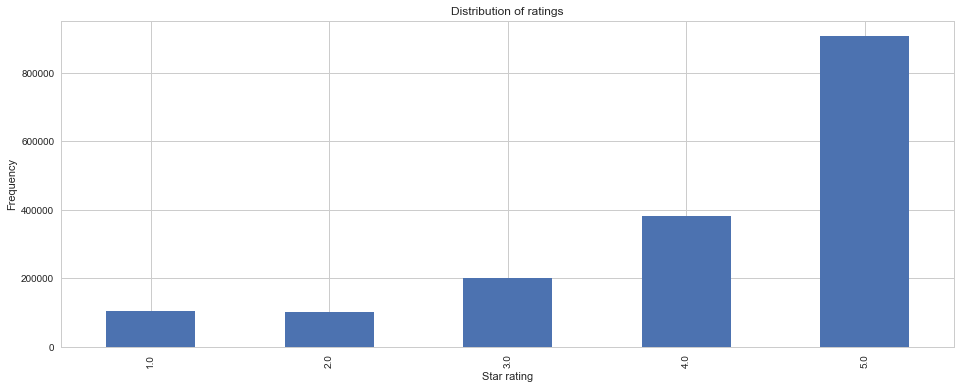

In [8]:
ax = rating_dist.sort_values(by = 'overall').plot(kind='bar', x = 'overall', y = 'count', figsize = (16,6))
__ = ax.set(title = 'Distribution of ratings', xlabel = 'Star rating', ylabel = 'Frequency')
ax.legend().remove()

# Number of reviews per reviewer
Next, we calculate the number of reviews written by each reviewer, sort each reviewer in descending order by their number of reviews written, and plot the reviewer's sorted rank against their number of reviews. We observe the typical long-tail distribution where a small number of reviewers are highly prolific while the vast majority of reviewers write only a few reviews. This gives us confidence that the data has been processed correctly.

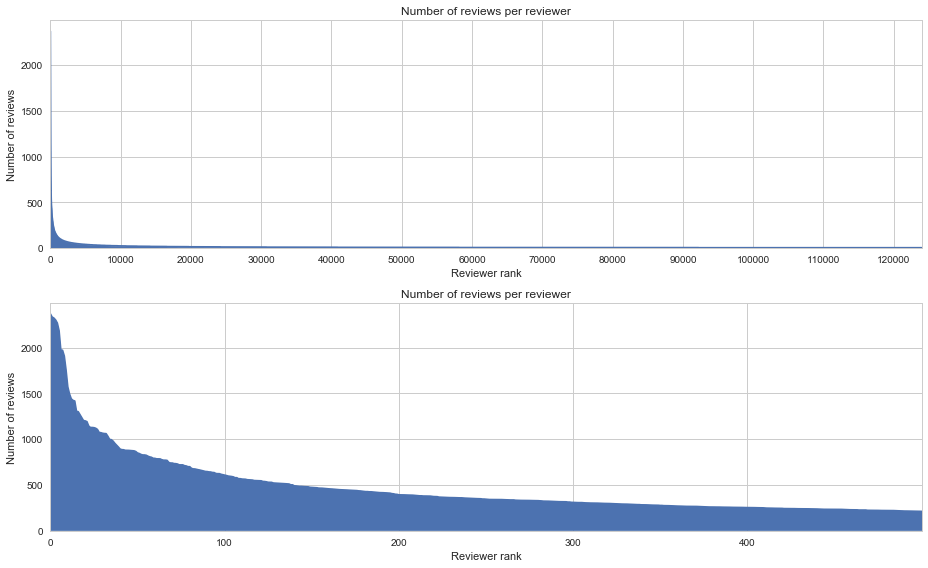

In [9]:
# calculate reviews per reviewer and sort reviewers
review_counts = sdf.groupby('reviewerID').count().toPandas()
review_counts = review_counts.sort_values(by = 'count', ascending = False)

# two-plot figure
fig, axes = plt.subplots(2, 1, figsize = (13,8))

# plot all reviewers
review_counts.plot(kind = 'area', x = 'reviewerID', y = 'count', ax = axes[0])
__ = axes[0].set(xticks = range(0, len(review_counts), int(1e4)), xticklabels = range(0, len(review_counts), int(1e4)))
__ = axes[0].set(title = 'Number of reviews per reviewer', xlabel = 'Reviewer rank', ylabel = 'Number of reviews')
axes[0].legend().remove()

# plot top 500 reviewers
review_counts.plot(kind = 'area', x = 'reviewerID', y = 'count', ax = axes[1])
__ = axes[1].set(xlim = (0, 500), xticks = range(0, 500, 100), xticklabels = range(0, 500, 100))
__ = axes[1].set(title = 'Number of reviews per reviewer', xlabel = 'Reviewer rank', ylabel = 'Number of reviews')
axes[1].legend().remove()

plt.tight_layout()

Below are some summary statistics:
- The average review count per reviewer is 14 while the median is only 7.
- The minimum review count per reviewer is 5, as expected from the definition of the 5-core dataset.

In [10]:
review_counts['count'].describe()

count    123960.000000
mean         13.694200
std          39.750989
min           5.000000
25%           5.000000
50%           7.000000
75%          11.000000
max        2368.000000
Name: count, dtype: float64

# Number of reviews per item
We perform a similar analysis as above but count number of reviews per item. Again, we observe a reassuring long-tailed distribution.

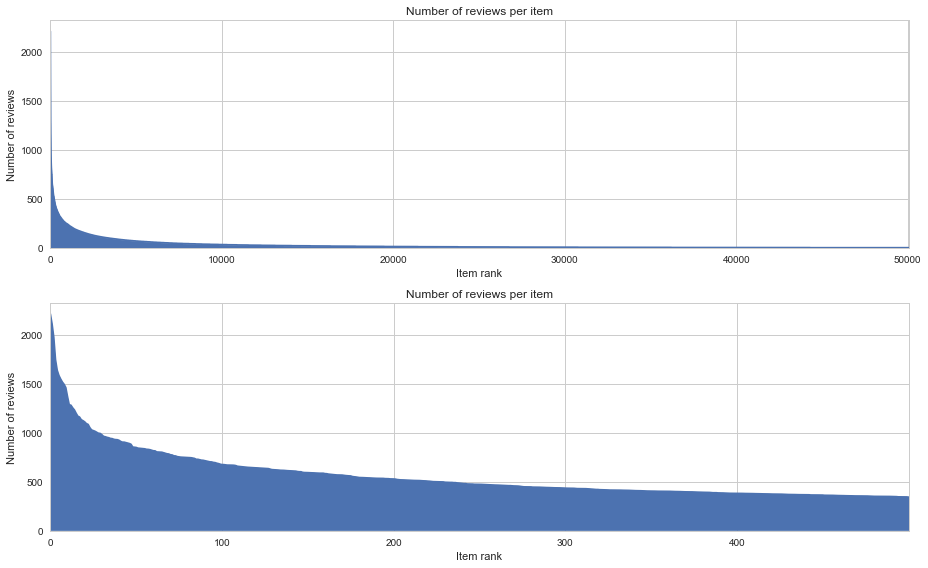

In [11]:
# calculate reviews per item and sort items
review_counts_2 = sdf.groupby('asin').count().toPandas()
review_counts_2 = review_counts_2.sort_values(by = 'count', ascending = False)

# two-plot figure
fig, axes = plt.subplots(2, 1, figsize = (13,8))

# plot all items
review_counts_2.plot(kind = 'area', x = 'asin', y = 'count', ax = axes[0])
__ = axes[0].set(xticks = range(0, len(review_counts_2), int(1e4)), xticklabels = range(0, len(review_counts_2),int(1e4)))
__ = axes[0].set(title = 'Number of reviews per item', xlabel = 'Item rank', ylabel = 'Number of reviews')
axes[0].legend().remove()

# plot top 500 most reviewed items
review_counts_2.plot(kind = 'area', x = 'asin', y = 'count', ax = axes[1])
__ = axes[1].set(xlim = (0, 500), xticks = range(0, 500, 100), xticklabels = range(0, 500, 100))
__ = axes[1].set(title = 'Number of reviews per item', xlabel = 'Item rank', ylabel = 'Number of reviews')
axes[1].legend().remove()

plt.tight_layout()

Because there are far fewer items than reviewers, we naturally expect that the median and average review count per item is higher than that per reviewer.

In [12]:
review_counts_2['count'].describe()

count    50052.000000
mean        33.915388
std         73.466260
min          5.000000
25%          7.000000
50%         13.000000
75%         29.000000
max       2213.000000
Name: count, dtype: float64

# Average rating per reviewer
Next, we calculate the average star rating for each reviewer, sort each reviewer in descending order by their average star rating, and plot the reviewer's sorted rank against their average star rating. We observe that over 90% of reviewers give average star ratings above a 3. Intuitively, this makes sense because people tend to only purchase items already like or believe they will like. It is also possible that the act of purchasing an item predisposes a customer to liking it.

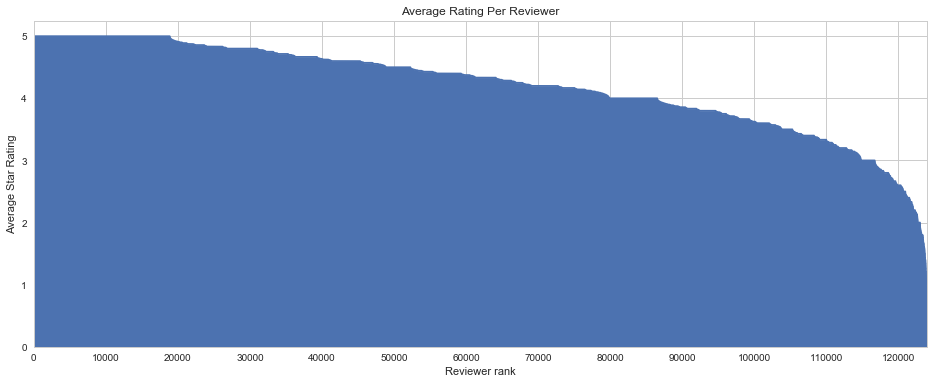

In [7]:
avg_rating = sdf.groupby("reviewerID").mean().toPandas()
avg_rating = avg_rating.sort_values(by = "avg(overall)", ascending = False).reset_index()
ax = avg_rating.plot(kind = "area", x = "reviewerID", y = "avg(overall)", figsize = (16, 6))
ax.set(title = "Average Rating Per Reviewer", ylabel = "Average Star Rating", xlabel = 'Reviewer rank')
ax.set(xticks = range(0, len(avg_rating), int(1e4)), xticklabels = range(0, len(avg_rating), int(1e4)))
ax.legend().remove()

The typical reviewer rates items with an average of 4.2 stars.

count    123960.000000
mean          4.201630
std           0.698599
min           1.000000
25%           3.800000
50%           4.333333
75%           4.800000
max           5.000000
Name: avg(overall), dtype: float64

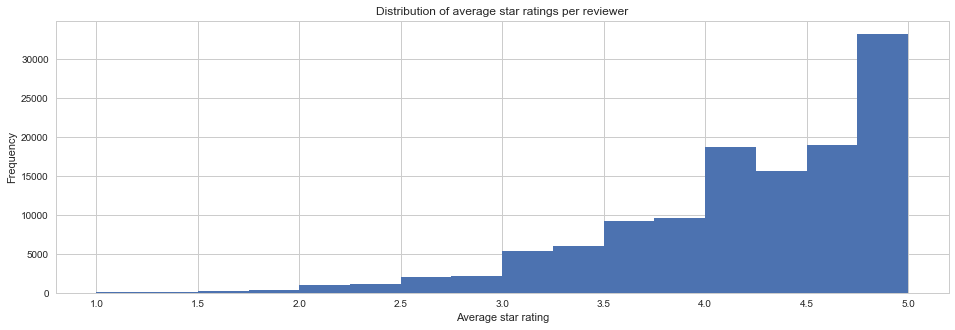

In [25]:
ax = avg_rating['avg(overall)'].hist(figsize = (16,5), bins = 16)
__ = ax.set(title = 'Distribution of average star ratings per reviewer', xlabel = 'Average star rating', ylabel = 'Frequency')

avg_rating['avg(overall)'].describe()

# Average rating per item
The distribution of average star ratings per item is slightly different than that per reviewer. It appears the ratings are less positively skewed; a smaller proportion of movies have an average rating of 5 stars, and a smaller proportion of movies have an average rating of above 3 stars.

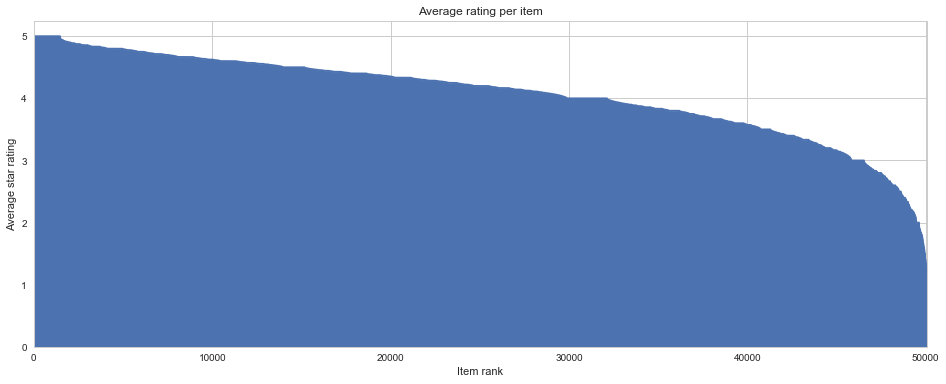

In [17]:
avg_rating_2 = sdf.groupby("asin").mean().toPandas()
avg_rating_2 = avg_rating_2.sort_values(by = "avg(overall)", ascending = False).reset_index()
ax = avg_rating_2.plot(kind = "area", x = "asin", y = "avg(overall)", figsize = (16, 6))
ax.set(title = "Average rating per item", ylabel = "Average star rating", xlabel = 'Item rank')
ax.set(xticks = range(0, len(avg_rating_2), int(1e4)), xticklabels = range(0, len(avg_rating_2), int(1e4)))
ax.legend().remove()

The difference in distributions is clearer in the histogram below, where the mode of the distribution is at approximately between 4 and 4.5 stars rather than at 4.75 stars.

count    50052.000000
mean         4.063543
std          0.662038
min          1.000000
25%          3.714286
50%          4.200000
75%          4.562500
max          5.000000
Name: avg(overall), dtype: float64

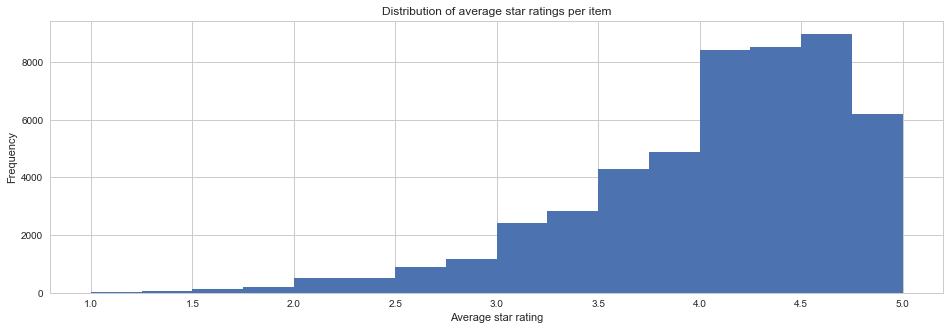

In [24]:
ax = avg_rating_2['avg(overall)'].hist(figsize = (16,5), bins = 16)
__ = ax.set(title = 'Distribution of average star ratings per item', xlabel = 'Average star rating',
            ylabel = 'Frequency')

avg_rating_2['avg(overall)'].describe()

# Number of reviews over time
The number of reviews per month is relatively stable from December 1999 to June 2012. On September 4, 2012, Amazon signed a deal with Epix to feature a much larger library of popular movies that may have contributed to the rise in reviews.

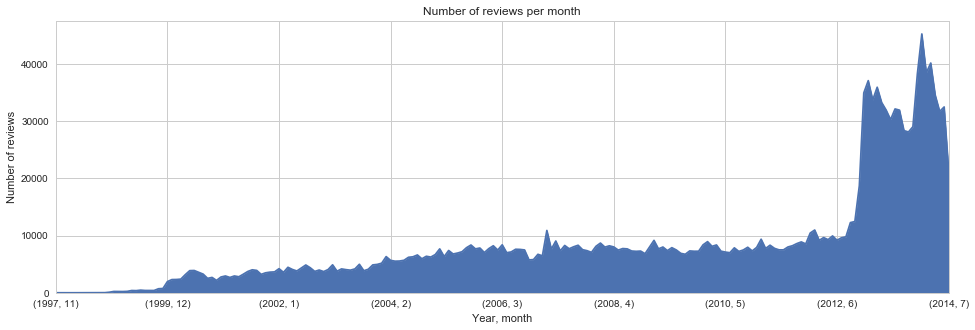

In [56]:
time_count = sdf.groupby('reviewTime').count().toPandas()
time_count['reviewTime'] = pd.to_datetime(time_count['reviewTime'])

time_count['month'] = time_count['reviewTime'].apply(lambda x: x.month)
time_count['year'] = time_count['reviewTime'].apply(lambda x: x.year)

ax = time_count.groupby(['year','month'])['count'].sum().plot(kind = 'area', figsize = (16,5))
ax.set(title = 'Number of reviews per month', xlabel = 'Year, month', ylabel = 'Number of reviews')
ax.legend().remove()